In [1]:
import os
import pickle
import logging

import pandas as pd
import numpy as np

from hbmep.config import Config
from hbmep.model.utils import Site as site

from paper.utils import setup_logging
from models import NonHierarchicalBayesianModel
from constants import (
    TOML_PATH,
    BUILD_DIR
)


In [2]:
src = "/home/vishu/data/hbmep-processed/rat/L_SHIE/data.csv"

df = pd.read_csv(src)
df.shape


(3572, 46)

In [3]:
columns = ["participant", "compound_position", "compound_charge_params"]
combinations = df[columns].apply(tuple, axis=1).unique().tolist()


In [4]:
d = {}
for subject, position, charge in combinations:
    if (position, charge) in d:
        d[(position, charge)].append(subject)
    else:
        d[(position, charge)] = [subject]


In [9]:
df[columns[1:]].apply(tuple, axis=1).unique().tolist()

[('C6LX-C6LC', '50-0-50-100'),
 ('C6LC-', '20-0-80-25'),
 ('C6LC-C6LX', '20-0-80-25'),
 ('C6LC-C6LX', '50-0-50-100'),
 ('C6LC-', '50-0-50-100'),
 ('C6LX-C6LC', '20-0-80-25'),
 ('-C6LC', '20-0-80-25'),
 ('-C6LC', '50-0-50-100')]

In [10]:
df[]

,pulse_amplitude,pulse_train_frequency,pulse_period,pulse_duration,pulse_count,train_delay,channel1_1,channel1_2,channel1_3,channel1_4,...,channel1_segment,channel1_designation,channel2_laterality,channel2_segment,channel2_designation,compound_position,compound_charge_params,participant,subdir_pattern,charge_param_error
0,0,0.4,1,1.0,1,2,3,5,10,12,...,C6,X,L,C6,C,C6LX-C6LC,50-0-50-100,amap01,*L_SHIE*,NaN
1,0,0.4,1,1.0,1,2,3,5,10,12,...,C6,X,L,C6,C,C6LX-C6LC,50-0-50-100,amap01,*L_SHIE*,NaN
2,0,0.4,1,1.0,1,2,3,5,10,12,...,C6,X,L,C6,C,C6LX-C6LC,50-0-50-100,amap01,*L_SHIE*,NaN
3,0,0.4,1,1.0,1,2,3,5,10,12,...,C6,X,L,C6,C,C6LX-C6LC,50-0-50-100,amap01,*L_SHIE*,NaN
4,0,0.4,1,1.0,1,2,3,5,10,12,...,C6,X,L,C6,C,C6LX-C6LC,50-0-50-100,amap01,*L_SHIE*,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3567,150,0.4,1,1.0,1,2,3,5,10,12,...,C6,X,L,C6,C,C6LX-C6LC,20-0-80-25,amap08,*L_SHIE*,0.0
3568,150,0.4,1,1.0,1,2,6,0,0,0,...,C6,C,L,C6,X,C6LC-C6LX,20-0-80-25,amap08,*L_SHIE*,0.0
3569,150,0.4,1,0.4,1,2,0,0,0,0,...,NaN,NaN,L,C6,C,-C6LC,50-0-50-100,amap08,*L_SHIE*,0.0
3570,150,0.4,1,0.4,1,2,3,5,10,12,...,C6,X,L,C6,C,C6LX-C6LC,50-0-50-100,amap08,*L_SHIE*,0.0


In [8]:
[u for u, v in d.items() if len(v) == 8]

[('C6LX-C6LC', '50-0-50-100'),
 ('C6LC-', '20-0-80-25'),
 ('C6LC-C6LX', '20-0-80-25'),
 ('C6LC-C6LX', '50-0-50-100'),
 ('C6LC-', '50-0-50-100'),
 ('C6LX-C6LC', '20-0-80-25'),
 ('-C6LC', '20-0-80-25'),
 ('-C6LC', '50-0-50-100')]

In [4]:
df["compound_charge_params"]

0       50-0-50-100
1       50-0-50-100
2       50-0-50-100
3       50-0-50-100
4       50-0-50-100
           ...     
3567     20-0-80-25
3568     20-0-80-25
3569    50-0-50-100
3570    50-0-50-100
3571    50-0-50-100
Name: compound_charge_params, Length: 3572, dtype: object

In [3]:
config = Config(toml_path=TOML_PATH)
model = NonHierarchicalBayesianModel(config=config)


2024-07-08 09:55:10.707104: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
combinations = (
    df[model.features]
    .apply(tuple, axis=1)
    .unique()
    .tolist()
)
combinations = sorted(combinations)
len(combinations)


320

In [5]:
posterior_samples = {site.a: None}

for c in combinations:
    subject, position, shape = c
    dir = os.path.join(
        BUILD_DIR,
        f"sub__{subject}",
        f"pos__{position}",
        f"size__{shape}"
    )

    response_samples = None

    for response in model.response:
        src = os.path.join(
            dir, f"resp__{response}", model.NAME, "inference.pkl"
        )
        with open(src, "rb") as f:
            _, _, samples = pickle.load(f)

        for u in posterior_samples.keys():
            site_samples = samples[u].reshape(-1,)
            site_samples = site_samples[:, None, None]

            if response_samples is None:
                response_samples = site_samples
            else:
                response_samples = np.concatenate(
                    [response_samples, site_samples],
                    axis=-1
                )

    if posterior_samples[site.a] is None:
        posterior_samples[site.a] = response_samples
    else:
        posterior_samples[site.a] = np.concatenate(
            [posterior_samples[site.a], response_samples],
            axis=-2
        )


KeyboardInterrupt: 

In [ ]:
dest = os.path.join(BUILD_DIR, "inference.pkl")

with open(dest, "wb") as f:
    pickle.dump((combinations, posterior_samples,), f)


Saved figure to /home/vishu/charges.png


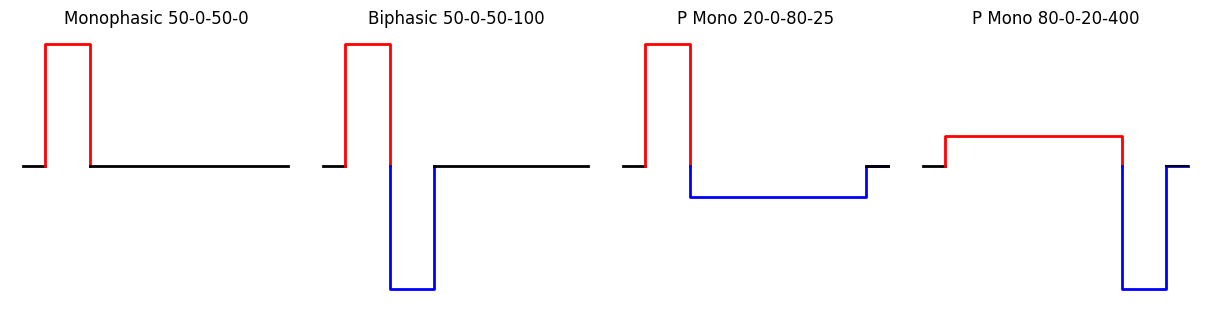

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_kwargs = {"linewidth": 2}

nrows, ncols = 1, 4
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(3 * ncols, 3 * nrows),
    sharex=True,
    sharey=True,
    constrained_layout=True,
    squeeze=False
)

# Monophasic 50-0-50-0
ax = axes[0, 0]
data = [
    [-50, 0],
    [0, 0],
]
x, y = zip(*data)
ax.plot(x, y, color="k", **plot_kwargs)

data = [
    [0, 0],
    [0, 50],
    [100, 50],
    [100, 0],
]
x, y = zip(*data)
ax.plot(x, y, color="r", **plot_kwargs)

data = [
    [100, 0],
    [250, 0],
    [550, 0]
]
x, y = zip(*data)
ax.plot(x, y, color="k", **plot_kwargs)
ax.set_title("Monophasic 50-0-50-0")

# Biphasic 50-0-50-100
ax = axes[0, 1]
data = [
    [-50, 0],
    [0, 0],
]
x, y = zip(*data)
ax.plot(x, y, color="k", **plot_kwargs)

ax = axes[0, 1]
data = [
    [0, 0],
    [0, 50],
    [100, 50],
    [100, 0],
]
x, y = zip(*data)
ax.plot(x, y, color="r", **plot_kwargs)

data = [
    [100, 0],
    [100, -50],
    [200, -50],
    [200, 0],
]
x, y = zip(*data)
ax.plot(x, y, color="b", **plot_kwargs)

data = [
    [200, 0],
    [250, 0],
    [550, 0]
]
x, y = zip(*data)
ax.plot(x, y, color="k", **plot_kwargs)

ax.set_title("Biphasic 50-0-50-100")

# P Mono 20-0-80-25
ax = axes[0, 2]
data = [
    [-50, 0],
    [0, 0],
]
x, y = zip(*data)
ax.plot(x, y, color="k", **plot_kwargs)

data = [
    [0, 0],
    [0, 50],
    [100, 50],
    [100, 0],
]
x, y = zip(*data)
ax.plot(x, y, color="r", **plot_kwargs)

data = [
    [100, 0],
    [100, -12.5],
    [500, -12.5],
    [500, 0],
    [550, 0]
]
x, y = zip(*data)
ax.plot(x, y, color="b", **plot_kwargs)

data = [
    [500, 0],
    [550, 0]
]
x, y = zip(*data)
ax.plot(x, y, color="k", **plot_kwargs)

ax.set_title("P Mono 20-0-80-25")

# P Mono 80-0-20-400
ax = axes[0, 3]
data = [
    [-50, 0],
    [0, 0],
]
x, y = zip(*data)
ax.plot(x, y, color="k", **plot_kwargs)

data = [
    [0, 0],
    [0, 12.5],
    [400, 12.5],
    [400, 0],
]
x, y = zip(*data)
ax.plot(x, y, color="r", **plot_kwargs)

data = [
    [400, 0],
    [400, -50],
    [500, -50],
    [500, 0],
    [550, 0]
]
x, y = zip(*data)
ax.plot(x, y, color="b", **plot_kwargs)

data = [
    [500, 0],
    [550, 0],
]
x, y = zip(*data)
ax.plot(x, y, color="k")
ax.set_title("P Mono 80-0-20-400")

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        sides = ["top", "right", "bottom", "left"]
        for side in sides:
            ax.spines[side].set_visible(False)
        ax.tick_params(
            axis="both",
            which="both",
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False
        )

dest = "/home/vishu/charges.png"
fig.savefig(dest, dpi=600)
print(f"Saved figure to {dest}")
